In [3]:
%load_ext autoreload
%autoreload 2
import CMethods
import torch
import elements
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp








In [4]:
input_distribution = CMethods.astra_file_to_ttm("test_plasma_file_protons.part", 10, "proton") #create input tensor from particle distribution file

print(input_distribution[0])
print(input_distribution.requires_grad)



tensor([-4.1014e-05, -1.8698e-01, -1.2264e-05, -5.5894e-02,  0.0000e+00,
        -8.0249e-02], dtype=torch.float64, grad_fn=<SelectBackward0>)
True


In [14]:


def track(n, param, n_length, input_dist):
    
    q = torch.tensor(sp.constants.elementary_charge)
    beta_s = torch.tensor(CMethods.beta(10, "proton"))
    gamma_s = CMethods.beta_to_gamma(beta_s)
    p_s = CMethods.beta_to_p(beta_s, "proton")
    print(p_s.requires_grad)

    r = torch.zeros([6, 6], dtype=torch.float64)

    k_0 = torch.mul(q, torch.tensor(param))
    k_1 = torch.mul(p_s, 2)
    k = torch.div(k_0, k_1)
    k_sq = torch.square(k)
    k_l = torch.mul(k,n_length)

    k_sq_l = torch.mul(k_sq,n_length)
    c = torch.cos(k_l)
    c_2 = torch.cos(torch.mul(2, k_l))
    s = torch.sin(k_l)
    s_2 = torch.sin(torch.mul(2, k_l))
    c_sq = torch.square(c)
    s_sq = torch.square(s)
    sc = torch.mul(s, c)
    beta_s_sq = torch.square(beta_s)
    double_beta_s = torch.mul(2, beta_s)
    double_beta_s_sq = torch.mul(2, beta_s_sq)
    gamma_s_sq = torch.square(gamma_s)

    k_l_div_double_beta = torch.div(k_l, double_beta_s)
    k_l_div_beta = torch.div(k_l, beta_s)
    k_sq_l_div_double_beta = torch.div(k_sq_l, double_beta_s)
    l_div_double_beta = torch.div(n_length, double_beta_s)

    r = r.clone()
    r[0, 0] = c_sq
    r[0, 1] = torch.div(sc, k)
    r[0, 2] = sc
    r[0, 3] = torch.div(s_sq, k)

    r[1, 0] = torch.mul(-k, sc)
    r[1, 1] = c_sq
    r[1, 2] = torch.mul(-k, s_sq)
    r[1, 3] = sc

    r[2, 0] = -sc
    r[2, 1] = torch.div(-s_sq, k)
    r[2, 2] = c_sq
    r[2, 3] = torch.div(sc, k)

    r[3, 0] = torch.mul(k, s_sq)
    r[3, 1] = -sc
    r[3, 2] = torch.mul(-k, sc)
    r[3, 3] = c_sq

    r[4, 4] = 1
    r[4, 5] = torch.div(n_length, torch.mul(beta_s_sq, gamma_s_sq))

    r[5, 5] = 1

    working_dist = input_dist.clone()
    output_dist = working_dist.clone()
    
    rms_out = torch.empty(0, requires_grad=True)
    
    for i in range(n):

        output_bunch = torch.einsum('ik,jk->ji', [r, working_dist])
        working_dist = output_dist.clone()
        rms_out = torch.cat([rms_out, torch.std(output_bunch[:, 0]).unsqueeze(0)])

    return rms_out[-1]
    
    


In [15]:
class DanielsOptimizer(torch.nn.Module):

    def __init__(self, para):
        super().__init__()
        # register set of parameter:
        self.register_parameter('para',torch.nn.Parameter(para, requires_grad=True))

    def forward(self):
        # create lattice given quad strengths in k_set:
        input_temp = input_distribution.clone()
        sigma = track(100, self.para[0], self.para[1], input_temp)
        #sigma_x = torch.std(torch.tensor(sigma[0]))
        #sigma_y = torch.std(torch.tensor(sigma[1]))

        #sigma_target = torch.tensor(0.0001, dtype=torch.float64)# calculate and return loss function:
        sigma_target = 0.001
        dx = (sigma - sigma_target)
        
        #hier add zu sqrt
        return torch.sqrt(torch.add(torch.square(dx), torch.square(dx)))



def train_model(model, training_iter, alpha=0.1):
    history_param = [None] * training_iter  # list to save params
    history_loss = [None] * training_iter  # list to save loss

    # print the trainable parameters
    for param in model.named_parameters():
        print(f'{param[0]} : {param[1]}')

    # Use PyTorch Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), alpha)

    for i in range(training_iter):
    
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        loss = model()  # loss is just O.F.
        loss.backward()  # gradient#
        optimizer.step()
        
        # print info:
        if i % 10 == 0:  # print each 100 steps
            print('Iter %d/%d - Loss: %.5f ' % (
                i + 1, training_iter, loss
            ))

        # save loss and param
        for param in model.parameters():
            history_param[i] = param.data.detach().numpy().copy()
        history_loss[i] = loss.detach().numpy().copy()

        # optimization step
        

    # returns params and loss for every iteration
    return np.asarray(history_param), np.asarray(history_loss)



para : Parameter containing:
tensor([5.0000, 0.3000], dtype=torch.float64, requires_grad=True)
False
Iter 1/100 - Loss: 0.04598 
False
False
False
False
False
False
False
False
False
False
Iter 11/100 - Loss: 0.03019 
False
False
False
False
False
False
False
False


/var/folders/5y/_90vwzcx7wj7j56tcpjbgtz00000gn/T/ipykernel_27752/1072280642.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k_0 = torch.mul(q, torch.tensor(param))


False
False
Iter 21/100 - Loss: 0.01441 
False
False
False
False
False
False
False
False
False
False
Iter 31/100 - Loss: 0.00138 
False
False
False
False
False
False
False
False
False
False
Iter 41/100 - Loss: 0.00297 
False
False
False
False
False
False
False
False
False
False
Iter 51/100 - Loss: 0.00055 
False
False
False
False
False
False
False
False
False
False
Iter 61/100 - Loss: 0.00085 
False
False
False
False
False
False
False
False
False
False
Iter 71/100 - Loss: 0.00008 
False
False
False
False
False
False
False
False
False
False
Iter 81/100 - Loss: 0.00019 
False
False
False
False
False
False
False
False
False
False
Iter 91/100 - Loss: 0.00013 
False
False
False
False
False
False
False
False
False


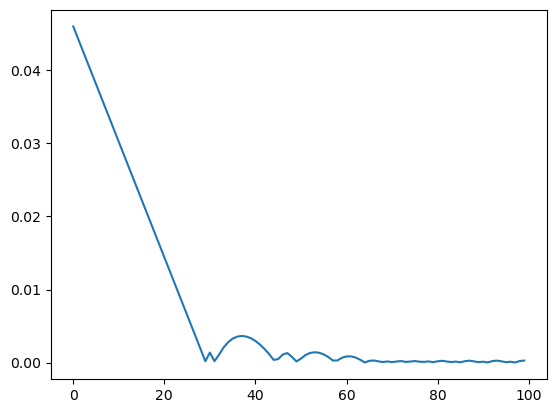

In [16]:
#k_set = torch.zeros(4)
k_set = torch.tensor([5, 0.3], requires_grad=True, dtype=torch.float64)

# Optimization
model = DanielsOptimizer(k_set)

params, loss = train_model(model, 100, 0.01)

plt.plot(loss)

In [8]:
print(loss)

NameError: name 'loss' is not defined